<a href="https://colab.research.google.com/github/AISaturdaysLagos/Cohort8-Bourguiba/blob/main/GPT_2_Fine_Tuning_Medical_FAQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Medical FAQ with PyTorch & Huggingface




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.



# Setup

In [ ]:
!pip install transformers

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!nvidia-smi

Fri Dec 15 15:43:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Create Training Set

The data used to finetune the language model is a multiple sets of above 17,000  medical questions and their answers, with the aim of generating them in the same general format and style.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# convert a json file to csv

import json

# Load the JSON file
with open('/content/drive/MyDrive/Team Bourguiba Dataset/health_assistant_115.json') as f:
    data = json.load(f)

# Convert JSON to DataFrame
df1 = pd.json_normalize(data)

# Save DataFrame to CSV
df1.to_csv('/content/drive/MyDrive/Team Bourguiba Dataset/health_assistant_115.csv', index=False)

In [ ]:
# load first dataset into a data frame
df1 = pd.read_csv ('/content/drive/MyDrive/Team Bourguiba Dataset/health_assistant_115.csv')
print(df1)

# Combine the question and answer column
df1['Ans_Que'] = df1.apply(lambda row:f"Question: {row['instruction']}\nAnswer: {row['output']}", axis=1)

# Made a copy of the Ans_Que column. We only need the Ans_Que
Ans_Que1 = df1.Ans_Que.copy()
Ans_Que1

                                           instruction  \
0    What are some practical steps I can take to im...   
1    What is a balanced diet and how can I ensure I...   
2    What are some effective strategies for incorpo...   
3    How can I manage stress and maintain a healthy...   
4    What are some tips for getting better quality ...   
..                                                 ...   
225                                        instruction   
226                                        instruction   
227                                        instruction   
228                                        instruction   
229                                        instruction   

                                                output  
0    1. Develop a consistent exercise routine – Exe...  
1    A balanced diet is one that includes all the e...  
2    1. Set specific times to exercise – Make it a ...  
3    1. Manage Your Time Wisely- Prioritize your ta...  
4    1. Try to go 

0      Question: What are some practical steps I can ...
1      Question: What is a balanced diet and how can ...
2      Question: What are some effective strategies f...
3      Question: How can I manage stress and maintain...
4      Question: What are some tips for getting bette...
                             ...                        
225                Question: instruction\nAnswer: output
226                Question: instruction\nAnswer: output
227                Question: instruction\nAnswer: output
228                Question: instruction\nAnswer: output
229                Question: instruction\nAnswer: output
Name: Ans_Que, Length: 230, dtype: object

In [ ]:
# load second dataset into a data frame
df2 = pd.read_csv ('/content/drive/MyDrive/Team Bourguiba Dataset/cpgQA-test.csv')
print(df2)

# Combine the question and answer column
df2['Ans_Que'] = df2.apply(lambda row:f"Question: {row['QUESTION']}\nAnswer: {row['ANSWER']}", axis=1)

# Made a copy of the Ans_Que column. We only need the Ans_Que
Ans_Que2 = df2.Ans_Que.copy()
Ans_Que2

                     TITLE                                            CONTEXT  \
0          Recommendations  We recommend against the concurrent use of ben...   
1          Recommendations  We recommend against long-term opioid therapy ...   
2    Features and overview  Use a shared decision-making approach to discu...   
3          Recommendations  If prescribing opioids, we recommend prescribi...   
4                Algorithm  When safety allows, a gradual taper rate (5-10...   
..                     ...                                                ...   
105        Recommendations  Community-based Needle Exchange Programs or Sy...   
106  Features and overview  Opioids are not first-line or routine therapy ...   
107        Recommendations  Prior to initiating OT, an individualized asse...   
108        Recommendations  In patients receiving LOT, moderate quality ev...   
109        Recommendations  All patients who take opioids chronically are ...   

                           

0      Question: What to consider for patients curren...
1      Question: What is recommended for patients cur...
2      Question: Name a sleep disorder.\nAnswer: Slee...
3      Question: What is the recommended dose of opio...
4      Question: What to do when there are concerns r...
                             ...                        
105    Question: What is an example of high-risk beha...
106    Question: What should be done before starting ...
107    Question: What to do after initiating OT?\nAns...
108    Question: In patients receiving LOT, who are 5...
109    Question: Who are at risk for OUD and overdose...
Name: Ans_Que, Length: 110, dtype: object

In [ ]:
# load third dataset into a data frame
df3 = pd.read_csv ('/content/drive/MyDrive/Team Bourguiba Dataset/cpgQA-train.csv')
print(df3)

# Combine the question and answer column
df3['Ans_Que'] = df3.apply(lambda row:f"Question: {row['QUESTION']}\nAnswer: {row['ANSWER']}", axis=1)

Ans_Que3 = df3.Ans_Que.copy() #just use the Ans_Que text in this example
Ans_Que3

                      TITLE  \
0     Features and overview   
1           Recommendations   
2                 Algorithm   
3    Background information   
4     Features and overview   
..                      ...   
872  Background information   
873         Recommendations   
874  Background information   
875         Recommendations   
876         Recommendations   

                                               CONTEXT  \
0    Here is an example of an opioid taper plan for...   
1    Opioid medications are potentially lethal and ...   
2    Module D is for patients currently on opioid t...   
3    Headache not responsive to other pain treatmen...   
4    Use a shared decision-making approach to discu...   
..                                                 ...   
872  Chronic pain is a national public health probl...   
873  A number of studies suggest certain chronic pa...   
874  Chronic pain is a national public health probl...   
875  The added risk that younger patients using

0      Question: How much to take from days 11 to 20,...
1      Question: For which patients the VA/DoD Suicid...
2      Question: What to do if there are factors that...
3      Question: What is an ineffective treatment mod...
4      Question: Name the treatment settings in which...
                             ...                        
872    Question: What was accompanying the increase i...
873    Question: Is there any evidence that certain c...
874    Question: What was increasing at an alarming r...
875    Question: What was the amount of risk of devel...
876    Question: What is recommended when risks of lo...
Name: Ans_Que, Length: 877, dtype: object

In [ ]:
# load fourth into a data frame
df4 = pd.read_csv ('/content/drive/MyDrive/Team Bourguiba Dataset/health_conv.csv')
print(df4)

# Combine the question and answer column
df4['Ans_Que'] = df4.apply(lambda row:f"Question: {row['Questions']}\nAnswer: {row['Answers']}", axis=1)

# Made a copy of the Ans_Que column. We only need the Ans_Que
Ans_Que4 = df4.Ans_Que.copy()
Ans_Que4

                                             Questions  \
0                              What is a panic attack?   
1    What are symptoms of panic attack vs. anxiety ...   
2                What are the types of Mental Illness?   
3                       What does mental-illness mean?   
4                    How can you treat mental illness?   
..                                                 ...   
149  How does smoking, drinking alcohol, or misusin...   
150            How does aging affect my mental health?   
151  How does physical activity affect my mental he...   
152  How do traumatic or negative childhood events ...   
153            Why is women’s mental health important?   

                                               Answers  
0    Panic attacks come on suddenly and involve int...  
1    Panic and anxiety attacks may feel similar, an...  
2    There are many different conditions that are r...  
3    Mental illness is a group of biological brain ...  
4    As these illn

0      Question: What is a panic attack?\nAnswer: Pan...
1      Question: What are symptoms of panic attack vs...
2      Question: What are the types of Mental Illness...
3      Question: What does mental-illness mean?\nAnsw...
4      Question: How can you treat mental illness?\nA...
                             ...                        
149    Question: How does smoking, drinking alcohol, ...
150    Question: How does aging affect my mental heal...
151    Question: How does physical activity affect my...
152    Question: How do traumatic or negative childho...
153    Question: Why is women’s mental health importa...
Name: Ans_Que, Length: 154, dtype: object

In [ ]:
# load fifth dataset into a data frame
df5 = pd.read_csv ('/content/drive/MyDrive/Team Bourguiba Dataset/medquad.csv')
print(df5)

# Combine the question and answer column
df5['Ans_Que'] = df5.apply(lambda row:f"Question: {row['question']}\nAnswer: {row['answer']}", axis=1)

# Made a copy of the Ans_Que column. We only need the Ans_Que
Ans_Que5 = df5.Ans_Que.copy()
Ans_Que5

                                                question  \
0                               What is (are) Glaucoma ?   
1                                 What causes Glaucoma ?   
2                    What are the symptoms of Glaucoma ?   
3                 What are the treatments for Glaucoma ?   
4                               What is (are) Glaucoma ?   
...                                                  ...   
16407  What is (are) Diabetic Neuropathies: The Nerve...   
16408  How to prevent Diabetic Neuropathies: The Nerv...   
16409  How to diagnose Diabetic Neuropathies: The Ner...   
16410  What are the treatments for Diabetic Neuropath...   
16411  What to do for Diabetic Neuropathies: The Nerv...   

                                                  answer           source  \
0      Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1      Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2      Symptoms of Glaucoma  Glaucoma can develo

0        Question: What is (are) Glaucoma ?\nAnswer: Gl...
1        Question: What causes Glaucoma ?\nAnswer: Near...
2        Question: What are the symptoms of Glaucoma ?\...
3        Question: What are the treatments for Glaucoma...
4        Question: What is (are) Glaucoma ?\nAnswer: Gl...
                               ...                        
16407    Question: What is (are) Diabetic Neuropathies:...
16408    Question: How to prevent Diabetic Neuropathies...
16409    Question: How to diagnose Diabetic Neuropathie...
16410    Question: What are the treatments for Diabetic...
16411    Question: What to do for Diabetic Neuropathies...
Name: Ans_Que, Length: 16412, dtype: object

In [ ]:

# Combine the dataframes
combined_df = pd.concat([Ans_Que1, Ans_Que2, Ans_Que3, Ans_Que4, Ans_Que5], ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_df.to_csv('/content/drive/MyDrive/Team Bourguiba Dataset/combined_df.csv', index=False)

In [ ]:
# load combined dataset into a data frame
combined_df = pd.read_csv ('/content/drive/MyDrive/Team Bourguiba Dataset/combined_df.csv')
print(combined_df)

                                                 Ans_Que
0      Question: What are some practical steps I can ...
1      Question: What is a balanced diet and how can ...
2      Question: What are some effective strategies f...
3      Question: How can I manage stress and maintain...
4      Question: What are some tips for getting bette...
...                                                  ...
17778  Question: What is (are) Diabetic Neuropathies:...
17779  Question: How to prevent Diabetic Neuropathies...
17780  Question: How to diagnose Diabetic Neuropathie...
17781  Question: What are the treatments for Diabetic...
17782  Question: What to do for Diabetic Neuropathies...

[17783 rows x 1 columns]


In [ ]:
combined_df.dropna(inplace=True) #remove NA values

In [ ]:
# Made a copy of combined datasets. Which contains only the Ans_Que column that we need
combined_df2 = combined_df.copy()
combined_df2

,Ans_Que
0,Question: What are some practical steps I can ...
1,Question: What is a balanced diet and how can ...
2,Question: What are some effective strategies f...
3,Question: How can I manage stress and maintain...
4,Question: What are some tips for getting bette...
...,...
17778,Question: What is (are) Diabetic Neuropathies:...
17779,Question: How to prevent Diabetic Neuropathies...
17780,Question: How to diagnose Diabetic Neuropathie...
17781,Question: What are the treatments for Diabetic...


In [ ]:
#Use the column name here
Ans_Que = combined_df2.Ans_Que.copy()
Ans_Que
#print(Ans_Que.loc[0])

0        Question: What are some practical steps I can ...
1        Question: What is a balanced diet and how can ...
2        Question: What are some effective strategies f...
3        Question: How can I manage stress and maintain...
4        Question: What are some tips for getting bette...
                               ...                        
17778    Question: What is (are) Diabetic Neuropathies:...
17779    Question: How to prevent Diabetic Neuropathies...
17780    Question: How to diagnose Diabetic Neuropathie...
17781    Question: What are the treatments for Diabetic...
17782    Question: What to do for Diabetic Neuropathies...
Name: Ans_Que, Length: 17783, dtype: object

We need to get an idea of how long our training documents are.

Using a simple one just to get a rough understanding.

<ipython-input-16-d832bee94024>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

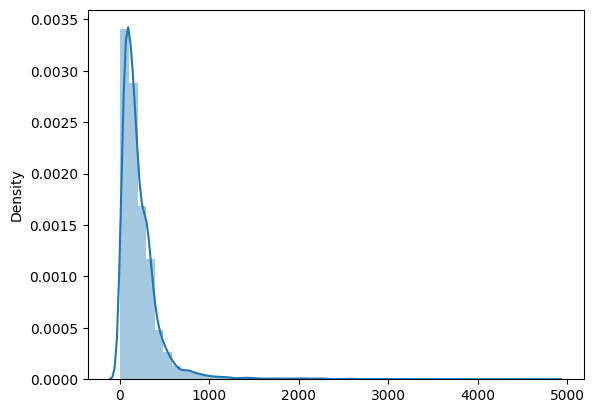

In [ ]:
doc_lengths = []

for Question in Ans_Que:

    # get rough token count distribution
    tokens = nltk.word_tokenize(Question)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.030253613001180905

In [ ]:
np.average(doc_lengths)

225.40240679300456

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Specify some of the special tokens.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. We learnt that increasing the batch size above 2 has lead to out of memory problems.

In [ ]:
batch_size = 2

We are using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We are passing in the tokenizer as an argument.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=1371):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

We wrapped each Ans_Que in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the Ans_Que is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(Ans_Que, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,004 training samples
1,779 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# We are not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because we've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# These parameters  work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)
pd.options.display.precision = 2

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

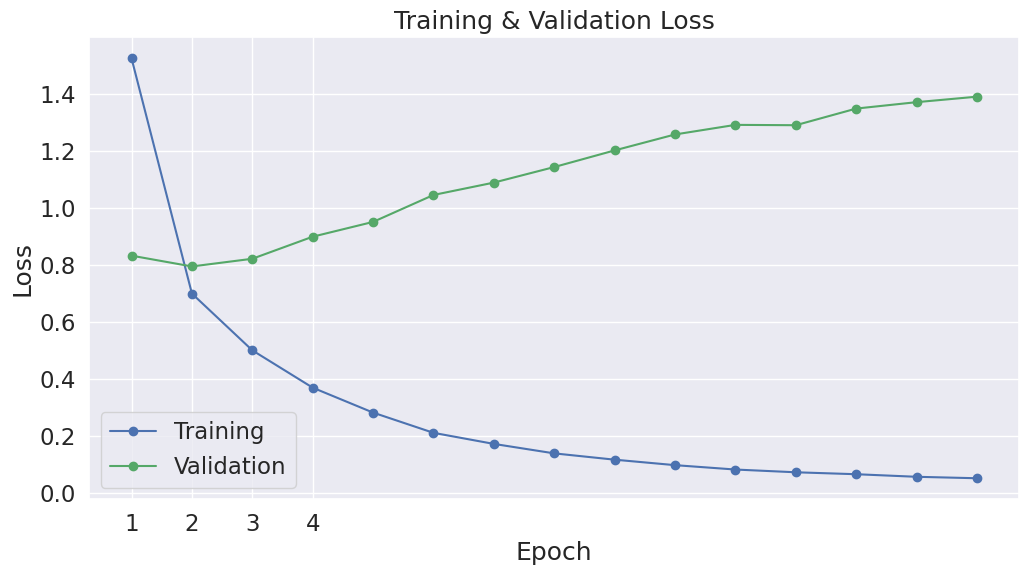

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving model with defaults name, so that it can be reloaded from_pretrained()

output_dir = '/content/drive/MyDrive/Team Bourguiba Dataset/model_save/'

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

args = {
    epochs: epochs,
    learning_rate: learning_rate,
    warmup_steps: warmup_steps,
    epsilon: epsilon,
    sample_every: sample_every
}
# save training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/MyDrive/Team Bourguiba Dataset/model_save/


In [ ]:
# Need to be in this locale to save model
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
#List all that is saved in the model
!ls -l --block-size=K ./model_save/

total 487568K
-rw-r--r-- 1 root root      1K Dec 15 16:10 added_tokens.json
-rw-r--r-- 1 root root      1K Dec 15 16:10 config.json
-rw-r--r-- 1 root root      1K Dec 15 16:10 generation_config.json
-rw-r--r-- 1 root root    446K Dec 15 16:10 merges.txt
-rw-r--r-- 1 root root 486114K Dec 15 16:10 model.safetensors
-rw-r--r-- 1 root root      1K Dec 15 16:10 special_tokens_map.json
-rw-r--r-- 1 root root      1K Dec 15 16:10 tokenizer_config.json
-rw-r--r-- 1 root root      1K Dec 15 16:10 training_args.bin
-rw-r--r-- 1 root root    976K Dec 15 16:10 vocab.json


In [ ]:
#Get details about the model weight
!ls -l --block-size=M ./model_save/model.safetensors

-rw-r--r-- 1 root root 475M Dec 15 16:10 ./model_save/model.safetensors


In [ ]:
#  Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

# Generate Text

In [ ]:
model.eval()

#prompt = "<|startoftext|>"
Questions = "What is a panic attack?"
prompt = f"<|startoftext|>Question:{Questions}\nAnswer: "

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

##Credit

 We've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).



This [discussion by harryenigma](https://discuss.huggingface.co/t/fine-tuning-gpt2-for-movie-script-generation-in-pytorch/23906/3) on Hugging Face was fundamental to the success of this project.


